# CSC420 Assignment 3 Question 3

In [299]:
import matplotlib.pyplot as plt
import scipy
import cv2
import numpy as np
import math
from scipy.special import softmax

Import images

In [ ]:
raw_image = cv2.imread('Q3_img.jpg', cv2.IMREAD_GRAYSCALE)
raw_image_colored = cv2.imread('Image.jpg')
corp_image = cv2.resize(raw_image, (900, 1200), interpolation = cv2.INTER_AREA)
shape = np.array(corp_image).shape
plt.imshow(corp_image, cmap='gray')
plt.imshow
print(corp_image.shape)

In [304]:
sobelx = np.array(cv2.Sobel(corp_image, cv2.CV_64F, 1, 0, ksize=3))
sobely = np.array(cv2.Sobel(corp_image, cv2.CV_64F, 0, 1, ksize=3))
gradient = np.array([sobelx, sobely])
gradient = gradient.transpose(1, 2, 0)

gradient_magnitude = np.sqrt(sobelx * sobelx + sobely * sobely)

print(gradient.shape)

(1200, 900, 2)


In [ ]:
def clip_and_count(gradient, threshold=50):
    flags = 0 * np.ones(shape=(gradient.shape[0], gradient.shape[1]), dtype=int)
    height = gradient.shape[0]
    width = gradient.shape[1]
    groups = []
    for h in range(height):
        for w in range(width):
            magnitude = np.linalg.norm(gradient[h][w])
            if magnitude >= threshold:
                ratio = np.divide(gradient[h][w][0], gradient[h][w][1],
                                  out=np.zeros_like(gradient[h][w][0]), where=gradient[h][w][1]!=0)
                direction = (np.arctan(ratio) * 180 / math.pi)
                if direction >= 0:
                    group = int((direction + 15) / 30)
                else:
                    group = int((180 - np.abs(direction) + 15) / 30)
                flags[h][w] = group + 1
                if group not in groups:
                    groups.append(group)
                    groups.append(direction)
    print(groups)
    flags[flags > 6] = 1
    return flags

In [ ]:
flags = clip_and_count(gradient)
print(flags.shape)

In [ ]:
def count_by_boxes(flags, tau=25):
    height = flags.shape[0]
    width = flags.shape[1]
    grouped = np.zeros(shape=(tau, tau, 6), dtype=int)
    dy = int(height/tau)
    dx = int(width/tau)
    for h in range(tau):
        for w in range(tau):
            start_h = h * dy
            end_h = start_h + dy
            strat_w = w * dx
            end_w = strat_w + dx
            slice = flags[start_h:end_h]
            # print(slice.shape)
            block = slice.T[strat_w:end_w].flatten()
            print(block.shape)
            for k in range(6):
                grouped[h][w][k] = np.count_nonzero(block == (k+1))
    return grouped

In [ ]:
grouped = count_by_boxes(flags)

In [ ]:
print(grouped)

In [321]:
def graph_by_box(image, grouped, tau=25):
    shape = image.shape
    dx = int(shape[0] / tau)
    dy = int(shape[1] / tau)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 20, forward=True)
    ax.imshow(image, cmap='gray')
    for i in range(tau):
        for j in range(tau):
            x_pos = i * dx + int(dx/2)
            y_pos = j * dy + int(dy/2)
            for k in range(6):
                val = grouped[i][j][k]
                group = grouped[i][j]
                normalized = softmax(group)
                x_ratio = np.cos(k * math.pi / 6)
                y_ratio = np.sin(k * math.pi / 6)
                # magnitude = val / max(np.sum(grouped), 1)
                magnitude = normalized[k]
                x_direct = x_ratio * magnitude
                y_direct = y_ratio * magnitude
                ax.quiver(y_pos, x_pos, x_direct, y_direct, width=0.002, scale=2, scale_units='inches')
                ax.quiver(y_pos, x_pos, -x_direct, -y_direct, width=0.002,
                          scale=2, scale_units='inches')
    plt.show()
    return None

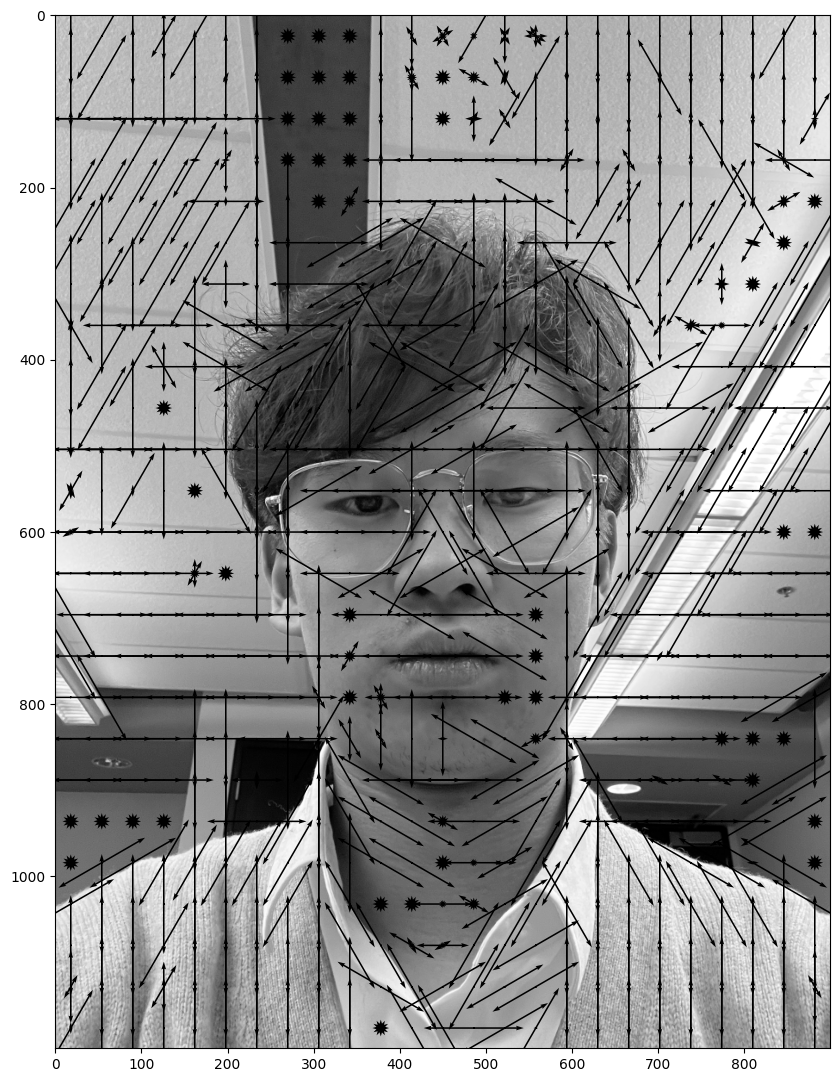

In [303]:
graph_by_box(corp_image, grouped)

In [318]:
def add_by_boxes(magnitude, flags, tau=25):
    grouped = np.zeros(shape=(tau, tau, 6), dtype=float)
    height = flags.shape[0]
    width = flags.shape[1]
    dy = int(height/tau)
    dx = int(width/tau)
    for h in range(tau):
        for w in range(tau):
            start_h = h * dy
            end_h = start_h + dy
            strat_w = w * dx
            end_w = strat_w + dx
            flag_slice = flags[start_h:end_h]
            magnitude_slice = magnitude[start_h:end_h]
            flag_block = flag_slice.T[strat_w:end_w].flatten()
            magnitude_block = magnitude_slice.T[strat_w:end_w].flatten()
            for k in range(6):
                indices = np.where(flag_block == (k+1))
                vals = np.take(magnitude_block, indices)
                grouped[h][w][k] = np.sum(vals)
    return grouped

In [319]:
added = add_by_boxes(gradient_magnitude, flags)

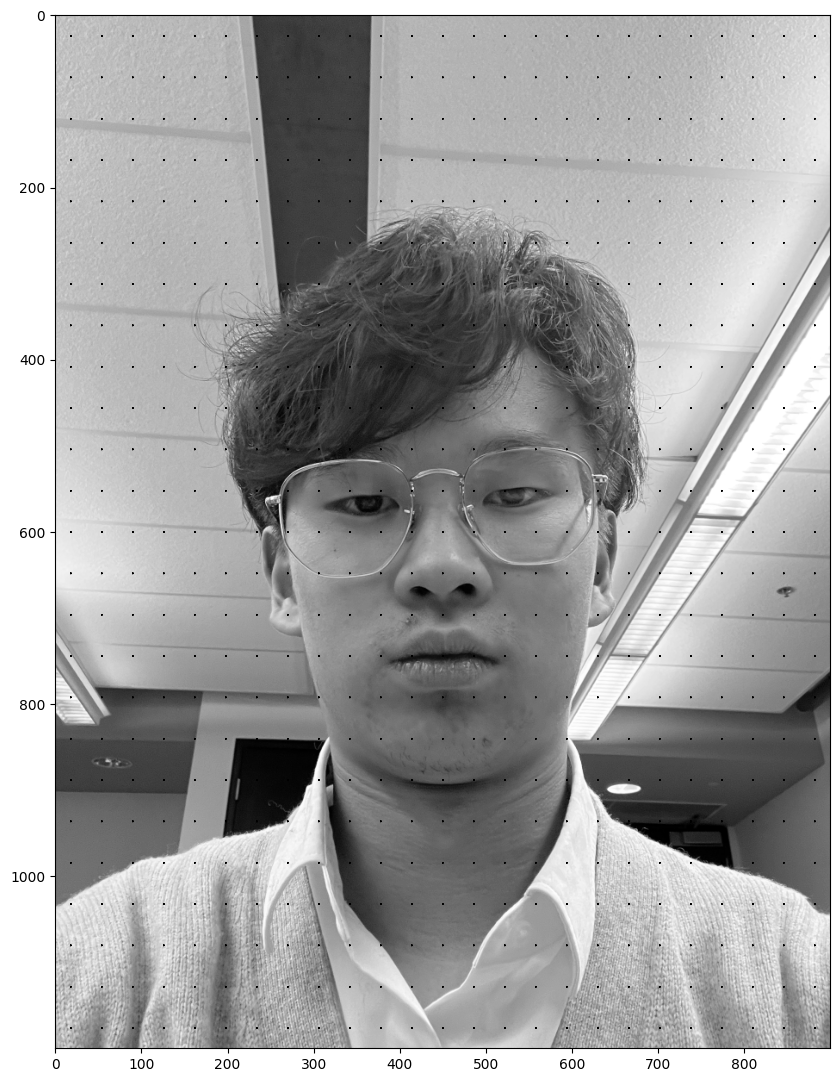

In [322]:
graph_by_box(corp_image, added)